In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [9]:
!pip install tifffile

# **Import Drive**

In [2]:

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


### **Sentinel-2 Land-Cover Subet Dataset with 5 Categories, having 100 images each**

In [206]:
import tifffile
from PIL import Image
from torchvision.transforms import ToTensor

files_0 = os.listdir(aerial_path+'/0/')
files_1 = os.listdir(aerial_path+'/1/')
files_2 = os.listdir(aerial_path+'/2/')
files_3 = os.listdir(aerial_path+'/3/')
files_4 = os.listdir(aerial_path+'/4/')



img_rgb_0  = Image.open(aerial_path + '/0/' + files[5])
img_rgb_1  = Image.open(aerial_path + '/1/' + files[15])
img_rgb_2  = Image.open(aerial_path + '/2/' + files[45])
img_rgb_3  = Image.open(aerial_path + '/3/' + files[30])
img_rgb_4  = Image.open(aerial_path + '/4/' + files[70])


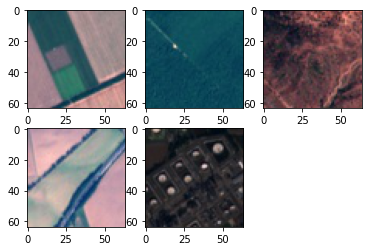

In [207]:
plt.subplot(231)
plt.imshow(img_rgb_0)
plt.subplot(232)
plt.imshow(img_rgb_1)
plt.subplot(233)
plt.imshow(img_rgb_2)
plt.subplot(234)
plt.imshow(img_rgb_3)
plt.subplot(235)
plt.imshow(img_rgb_4)


# **Path to Aerial Dataset**
(A combination of samples from Small Village and Industrial Datasets from Sensefly)

In [129]:
aerial_path = '/content/drive/MyDrive/sentinel-2_rgb'

# **Aerial Dataset Class**

In [4]:
def get_sat_data(folder_path,transforms=None):
  if transforms:
    dataset_full = ImageFolder(folder_path,preprocessor)
  else:
    dataset_full = ImageFolder(folder_path,preprocessor)

  
  return dataset_full



In [128]:
'''
target = '/content/drive/MyDrive/sentinel-2_rgb/4/'
files = os.listdir(aerial_path+'/4/')
files.sort()
for file in tqdm(files):
  img_13  = tifffile.imread(aerial_path + '/4/' + file)
  img_bgr = img_13[:,:,1:4]
  #img = img_bgr[::-1]
  img = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  cv2.imwrite(target+file.split('.')[0]+'.jpg',img)
'''

100%|██████████| 101/101 [00:48<00:00,  2.07it/s]


In [86]:
'''
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP','.tif'
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images

class ImageFolder(torch.utils.data.Dataset):

  def __init__(self, root, transform=None, target_transform=None):
      classes, class_to_idx = find_classes(root)
      imgs = make_dataset(root, class_to_idx)
      if len(imgs) == 0:
          raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                              "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

      self.root = root
      self.imgs = imgs
      self.classes = classes
      self.class_to_idx = class_to_idx
      self.transform = transform
      self.target_transform = target_transform

  def __getitem__(self, index):

      path, target = self.imgs[index]
      #print(ok)
      #img = self.loader(path)
      img_13  = tifffile.imread(path)
      img_bgr = img_13[:,:,1:4]
      img = img_bgr[::-1]
      img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
      if self.transform is not None:
          img = self.transform(img)
      if self.target_transform is not None:
          target = self.target_transform(target)
      return img, target

  def __len__(self):
      return len(self.imgs)
'''

# **Dataset and Dataloader initialization**

In [133]:
#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225])
resize = transforms.Resize((224,224))



preprocessor = transforms.Compose([ resize, transforms.ToTensor(), normalize
                                   ])

aerial_dataset_full = get_sat_data(aerial_path,preprocessor)

# Creating data indices for training and validation splits:
dataset_size = len(aerial_dataset_full)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed= 101

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

aerial_train_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16, 
                                           sampler=train_sampler)
aerial_validation_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16,
                                                sampler=valid_sampler)

In [134]:
print(aerial_dataset_full[0])

(tensor([[[-1.6898, -1.6898, -1.6898,  ...,  0.3994,  0.3823,  0.3823],
         [-1.6898, -1.6898, -1.6898,  ...,  0.3994,  0.3823,  0.3823],
         [-1.6898, -1.6898, -1.6898,  ...,  0.3823,  0.3652,  0.3652],
         ...,
         [-2.0494, -2.0494, -2.0494,  ...,  1.0844,  1.1015,  1.1015],
         [-2.0494, -2.0494, -2.0494,  ...,  1.1015,  1.1187,  1.1187],
         [-2.0494, -2.0494, -2.0494,  ...,  1.1015,  1.1187,  1.1187]],

        [[-0.5651, -0.5651, -0.5651,  ..., -0.1800, -0.1975, -0.1975],
         [-0.5651, -0.5651, -0.5651,  ..., -0.1800, -0.1975, -0.1975],
         [-0.5651, -0.5651, -0.5651,  ..., -0.1975, -0.2150, -0.2150],
         ...,
         [-1.3004, -1.3004, -1.3004,  ...,  0.1702,  0.1877,  0.1877],
         [-1.2829, -1.2829, -1.2829,  ...,  0.1877,  0.2052,  0.2052],
         [-1.2829, -1.2829, -1.2829,  ...,  0.1877,  0.2052,  0.2052]],

        [[-0.6541, -0.6541, -0.6541,  ..., -0.2707, -0.2881, -0.2881],
         [-0.6541, -0.6541, -0.6541,  ..., -

In [131]:
num_classes = 5

# **Training and Validation/Test loop**

In [150]:
def training_and_validation_loop(epochs,xp_lr_scheduler,model,optmizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,saved_model_name):

  train_loss = []
  test_loss = []
  accuracy = []

  for e in range(epochs):
        step_lr_scheduler.step()
      
        #put model in training mode
        model.train()
        avg_loss = 0

        for i, (x,y) in enumerate(aerial_train_loader):
              optimizer.zero_grad()

              if gpu_flag:
                    img_var = Variable(x).cuda()
                    label_actual = Variable(y).cuda()
              else:
                    img_var = Variable(x)
                    label_actual = Variable(y)

              label_predicted = model.forward(img_var)
              loss = criterion(label_predicted,label_actual)
              loss.backward()
              
              if(i%10 == 0):
                    print(i, loss.item())
              avg_loss+=loss.item()
              optimizer.step()
              
        print("Done Training")
        train_loss.append(avg_loss*1.0/(i+1))
        
        #set model in evaluation mode
        model.eval()
        avg_loss = 0
        correct_pred = 0
        total_pred = 0
        
        for i, (x_test,y_test) in enumerate(aerial_validation_loader):

            if gpu_flag:
                img_test_var = Variable(x_test).cuda()
                label_test_var = Variable(y_test).cuda()
            else:
                img_test_var = Variable(x_test)
                label_test_var = Variable(y_test)

            label_predicted_test = model.forward(img_test_var)
            loss = criterion(label_predicted_test,label_test_var)
            avg_loss+=loss.item()
            vals, label_predicted = torch.max(label_predicted_test,1)

            correct_pred += (label_predicted.cpu().data.numpy()==label_test_var.cpu().data.numpy()).sum()
            total_pred += len(label_predicted_test.cpu())
        
        test_loss.append(avg_loss*1.0/i)
        accuracy.append(correct_pred*100.0/total_pred)
        print("Epoch: ", e, "Train Loss: ", train_loss[-1], "Test Loss: ", test_loss[-1], "Accuracy: ", accuracy[-1])
        
        #replace model saved 
        if accuracy[-1]>best_acc:
            best_acc = accuracy[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model_wts)
            torch.save(model,f'/content/drive/My Drive/sentinel-2/{saved_model_name}.pt')
            print("Saved model with accuracy: ", best_acc)

  return train_loss,test_loss,accuracy

# **VGG-16 Model Initialization**

In [151]:
# Initialize the model
model = models.vgg16(pretrained=True)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [152]:
# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

    
num_features = model.classifier[6].in_features
# Remove last layer
features = list(model.classifier.children())[:-1]

# Add our layer with 10 outputs
features.extend([nn.Linear(num_features, num_classes)])

# Replace the model classifier
model.classifier = nn.Sequential(*features) 

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


#preprocessor = transforms.Compose([resize,transforms.ToTensor(),normalize])


In [153]:

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

True
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [142]:
tqdm = partial(tqdm, position=0, leave=True)

# **VGG16 Model Training and Validation**

In [154]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_vgg,test_loss_vgg,accuracy_vgg = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'vgg16')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.5527842044830322
10 1.1667479276657104
20 0.4904910922050476
Done Training
Epoch:  0 Train Loss:  0.7880626530028306 Test Loss:  0.48988191597163677 Accuracy:  86.13861386138613
Saved model with accuracy:  86.13861386138613
0 0.49932748079299927
10 0.5737537741661072
20 0.31253236532211304
Done Training
Epoch:  1 Train Loss:  0.4315136923956183 Test Loss:  0.19656771731873354 Accuracy:  97.02970297029702
Saved model with accuracy:  97.02970297029702
0 0.2683732509613037
10 0.030051369220018387
20 0.023899676278233528
Done Training
Epoch:  2 Train Loss:  0.16336509306879285 Test Loss:  0.20336214414176843 Accuracy:  94.05940594059406
0 0.4393337070941925
10 0.021655520424246788
20 0.07452696561813354
Done Training
Epoch:  3 Train Loss:  0.17263744227910557 Test Loss:  0.3493415353198846 Accuracy:  93.06930693069307
0 0.06903021782636642
10 0.024842623621225357
20 0.19570061564445496
Done Training
Epoch:  4 Train Loss:  0.06718521419231994 Test Loss:  0.1708200064022094 Accuracy:  98

# **Resnet-50 Model Training and Validation**

In [158]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.resnet50(pretrained = True)

#append a new last layer
model.fc = nn.Linear(2048,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [159]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_resnet,test_loss_resnet,accuracy_resnet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'resnet50')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.6110183000564575
10 0.5589222311973572
20 1.349152684211731
Done Training
Epoch:  0 Train Loss:  0.9287485717437588 Test Loss:  0.9159820924202601 Accuracy:  72.27722772277228
Saved model with accuracy:  72.27722772277228
0 1.3665858507156372
10 0.2676994204521179
20 0.4635784924030304
Done Training
Epoch:  1 Train Loss:  0.5461058244109154 Test Loss:  1.049634374678135 Accuracy:  75.24752475247524
Saved model with accuracy:  75.24752475247524
0 0.3235670328140259
10 0.03906668722629547
20 0.2946530282497406
Done Training
Epoch:  2 Train Loss:  0.42483941780833095 Test Loss:  0.8813686346014341 Accuracy:  80.1980198019802
Saved model with accuracy:  80.1980198019802
0 1.0905179977416992
10 0.3394052982330322
20 0.44129037857055664
Done Training
Epoch:  3 Train Loss:  0.34826357662677765 Test Loss:  0.3741537357370059 Accuracy:  84.15841584158416
Saved model with accuracy:  84.15841584158416
0 0.23335310816764832
10 0.015993745997548103
20 0.22321070730686188
Done Training
Epoch:  4

# **Densenet (121) Model Training and Validation**

In [161]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.densenet121(pretrained = True)

#append a new last layer
model.fc = nn.Linear(1024,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [162]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_densenet,test_loss_densenet,accuracy_densenet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'densenet121')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 9.705202102661133
10 1.8997547626495361
20 0.2708981931209564
Done Training
Epoch:  0 Train Loss:  2.325413996210465 Test Loss:  4.114207178354263 Accuracy:  53.46534653465346
Saved model with accuracy:  53.46534653465346
0 0.655325710773468
10 1.1922310590744019
20 0.2323516458272934
Done Training
Epoch:  1 Train Loss:  0.8417523835714047 Test Loss:  1.111289491256078 Accuracy:  68.31683168316832
Saved model with accuracy:  68.31683168316832
0 0.8691451549530029
10 0.8151715993881226
20 1.1121634244918823
Done Training
Epoch:  2 Train Loss:  0.8161684715977082 Test Loss:  0.7000947905083498 Accuracy:  88.11881188118812
Saved model with accuracy:  88.11881188118812
0 0.10334624350070953
10 0.4691743850708008
20 0.027096794918179512
Done Training
Epoch:  3 Train Loss:  0.8315990215453964 Test Loss:  0.7349641422430674 Accuracy:  77.22772277227723
0 0.021810298785567284
10 0.11064959317445755
20 0.9100956320762634
Done Training
Epoch:  4 Train Loss:  0.5999822888093499 Test Loss:  0.49

# **ShuffleNet Model Training and Validation**

In [175]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.shufflenet_v2_x1_0(pretrained = True)
#append a new last layer
model.fc = nn.Linear(1024,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_run

In [176]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_shufflenet,test_loss_shufflenet,accuracy_shufflenet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'shufflenet')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.6033337116241455
10 1.6107604503631592
20 1.5923737287521362
Done Training
Epoch:  0 Train Loss:  1.6067176919717054 Test Loss:  1.8734468420346577 Accuracy:  13.861386138613861
Saved model with accuracy:  13.861386138613861
0 1.5837866067886353
10 1.582115650177002
20 1.582777976989746
Done Training
Epoch:  1 Train Loss:  1.596213868031135 Test Loss:  1.861076295375824 Accuracy:  13.861386138613861
0 1.6032180786132812
10 1.5895551443099976
20 1.6050935983657837
Done Training
Epoch:  2 Train Loss:  1.583980408998636 Test Loss:  1.8472758332888286 Accuracy:  31.683168316831683
Saved model with accuracy:  31.683168316831683
0 1.5536614656448364
10 1.56793212890625
20 1.5777385234832764
Done Training
Epoch:  3 Train Loss:  1.570602563711313 Test Loss:  1.8322415947914124 Accuracy:  34.65346534653465
Saved model with accuracy:  34.65346534653465
0 1.564038634300232
10 1.5339574813842773
20 1.5721039772033691
Done Training
Epoch:  4 Train Loss:  1.5625664316690886 Test Loss:  1.8287366

# **SqueezeNet Model Training and Validation**

In [179]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.squeezenet1_1(pretrained = True)
#append a new last layer
#model.fc = nn.Linear(1024,num_classes)

# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

    
# num_features = model.classifier[6].in_features
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model.num_classes = num_classes

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxP

In [180]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_squeezenet,test_loss_squeezenet,accuracy_squeezenet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'squeezenet')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.7215379476547241
10 1.6010282039642334
20 1.4354884624481201
Done Training
Epoch:  0 Train Loss:  1.4422244085715368 Test Loss:  1.635127862294515 Accuracy:  35.64356435643565
Saved model with accuracy:  35.64356435643565
0 1.3008087873458862
10 1.2585126161575317
20 0.783483624458313
Done Training
Epoch:  1 Train Loss:  1.208700737127891 Test Loss:  1.1290804743766785 Accuracy:  53.46534653465346
Saved model with accuracy:  53.46534653465346
0 1.0218905210494995
10 1.1352678537368774
20 1.1979849338531494
Done Training
Epoch:  2 Train Loss:  1.0654778755628145 Test Loss:  1.1282269656658173 Accuracy:  63.366336633663366
Saved model with accuracy:  63.366336633663366
0 0.9712321162223816
10 1.3727526664733887
20 1.3082871437072754
Done Training
Epoch:  3 Train Loss:  1.1262206114255464 Test Loss:  0.9444511830806732 Accuracy:  73.26732673267327
Saved model with accuracy:  73.26732673267327
0 1.116815209388733
10 0.6448909044265747
20 0.477353572845459
Done Training
Epoch:  4 Train 

# **Mobilenet-V3 Model Training and Validation**

In [183]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.mobilenet_v3_large(pretrained = True)
#append a new last layer


# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

model.classifier[3] = nn.Linear(1280,num_classes)    
# num_features = model.classifier[6].in_features
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#model.num_classes = num_classes

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), st

In [184]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_mobilenetv3,test_loss_mobilenetv3,accuracy_mobilenetv3 = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'mobilenetv3')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.6962727308273315
10 0.9379370808601379
20 0.5122504830360413
Done Training
Epoch:  0 Train Loss:  0.9164435823376362 Test Loss:  1.0266722242037456 Accuracy:  66.33663366336634
Saved model with accuracy:  66.33663366336634
0 0.36596229672431946
10 0.2600838541984558
20 0.3212284445762634
Done Training
Epoch:  1 Train Loss:  0.22065730765461922 Test Loss:  0.6730715930461884 Accuracy:  77.22772277227723
Saved model with accuracy:  77.22772277227723
0 0.10982154309749603
10 0.09889861196279526
20 0.004817329812794924
Done Training
Epoch:  2 Train Loss:  0.10280085442802654 Test Loss:  0.4956468492746353 Accuracy:  79.20792079207921
Saved model with accuracy:  79.20792079207921
0 0.023399077355861664
10 0.042387496680021286
20 0.17555740475654602
Done Training
Epoch:  3 Train Loss:  0.09921029331878974 Test Loss:  0.45173787077267963 Accuracy:  86.13861386138613
Saved model with accuracy:  86.13861386138613
0 0.004938613623380661
10 0.060320060700178146
20 0.05156673863530159
Done Tra

# **Resnext50 Model Training and Validation**

In [188]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.resnext50_32x4d(pretrained = True)
#append a new last layer


# Freeze training for all layers
#for param in model.features.parameters():
#    param.require_grad = False

model.fc = nn.Linear(2048,num_classes)    
# num_features = model.classifier[6].in_features
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#model.num_classes = num_classes

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_si

In [189]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_resnext50,test_loss_resnext50,accuracy_resnext50 = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'resnext50')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.6011916399002075
10 1.0162638425827026
20 0.2314624786376953
Done Training
Epoch:  0 Train Loss:  0.9264364407326167 Test Loss:  0.3514340395728747 Accuracy:  92.07920792079207
Saved model with accuracy:  92.07920792079207
0 0.1070927232503891
10 0.19874049723148346
20 0.017556529492139816
Done Training
Epoch:  1 Train Loss:  0.2772250609436574 Test Loss:  1.289975549094379 Accuracy:  89.10891089108911
0 0.28347036242485046
10 0.08403738588094711
20 0.9381603598594666
Done Training
Epoch:  2 Train Loss:  0.5000027325004339 Test Loss:  0.5131245429317156 Accuracy:  88.11881188118812
0 0.7235650420188904
10 0.15493351221084595
20 0.6514920592308044
Done Training
Epoch:  3 Train Loss:  0.5695049930363894 Test Loss:  0.6332099844391147 Accuracy:  83.16831683168317
0 0.04096861183643341
10 0.1745675653219223
20 1.43146812915802
Done Training
Epoch:  4 Train Loss:  0.267289810670683 Test Loss:  0.10521493883182605 Accuracy:  96.03960396039604
Saved model with accuracy:  96.03960396039604

In [218]:
#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225])
resize = transforms.Resize((299,299))



preprocessor = transforms.Compose([ resize, transforms.ToTensor(), normalize
                                   ])

aerial_dataset_full = get_sat_data(aerial_path,preprocessor)

# Creating data indices for training and validation splits:
dataset_size = len(aerial_dataset_full)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed= 101

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

aerial_train_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16, 
                                           sampler=train_sampler)
aerial_validation_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16,
                                                sampler=valid_sampler)



gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.inception_v3(pretrained = True)
#append a new last layer


# Freeze training for all layers
#for param in model.features.parameters():
#    param.require_grad = False

model.fc = nn.Linear(2048,num_classes)    
# num_features = model.classifier[6].in_features
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#model.num_classes = num_classes
model.aux_logits=False

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3),

In [219]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_inceptionv3,test_loss_inceptionv3,accuracy_inceptionv3= training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'inceptionv3')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.694513201713562
10 1.0917048454284668
20 0.49491679668426514
Done Training
Epoch:  0 Train Loss:  1.0073338030622556 Test Loss:  0.3565973962346713 Accuracy:  91.08910891089108
Saved model with accuracy:  91.08910891089108
0 0.520588755607605
10 0.2112034410238266
20 0.060612358152866364
Done Training
Epoch:  1 Train Loss:  0.3076208070493661 Test Loss:  0.54404117166996 Accuracy:  85.14851485148515
0 0.41368117928504944
10 0.42476990818977356
20 0.5938020944595337
Done Training
Epoch:  2 Train Loss:  0.4169445474847005 Test Loss:  0.5692161619663239 Accuracy:  84.15841584158416
0 0.5391332507133484
10 0.10983309149742126
20 0.6402960419654846
Done Training
Epoch:  3 Train Loss:  0.34146898268507075 Test Loss:  0.29244164874156314 Accuracy:  94.05940594059406
Saved model with accuracy:  94.05940594059406
0 0.020844949409365654
10 0.24728870391845703
20 0.08756891638040543
Done Training
Epoch:  4 Train Loss:  0.21987662808253214 Test Loss:  0.13971334944168726 Accuracy:  98.01980198

# **Accuracy Plot vs Epochs for All Models**

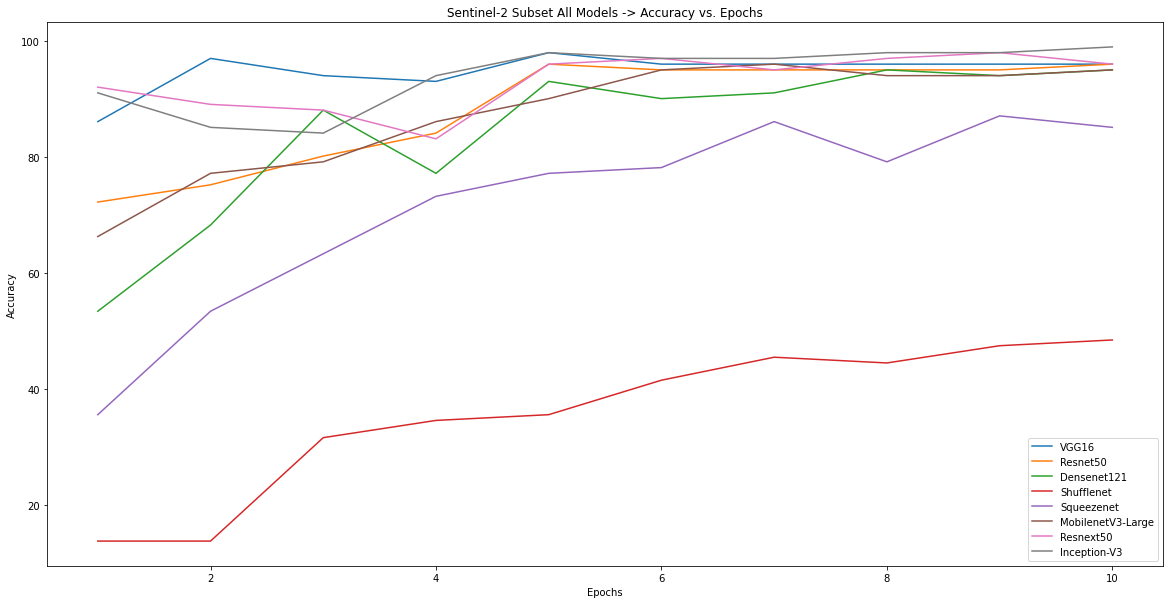

In [220]:
list_epochs = [i+1 for i in range(10)]

plt.figure(figsize = (20,10))


plt.plot(list_epochs,accuracy_vgg,label='VGG16')
plt.plot(list_epochs,accuracy_resnet,label='Resnet50')
plt.plot(list_epochs,accuracy_densenet,label='Densenet121')
plt.plot(list_epochs,accuracy_shufflenet,label='Shufflenet')
plt.plot(list_epochs,accuracy_squeezenet,label='Squeezenet')
plt.plot(list_epochs,accuracy_mobilenetv3,label='MobilenetV3-Large')
plt.plot(list_epochs,accuracy_resnext50,label='Resnext50')
plt.plot(list_epochs,accuracy_inceptionv3,label='Inception-V3')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sentinel-2 Subset All Models -> Accuracy vs. Epochs')
plt.legend()



# **Training Loss Plot vs Epochs for All Models**

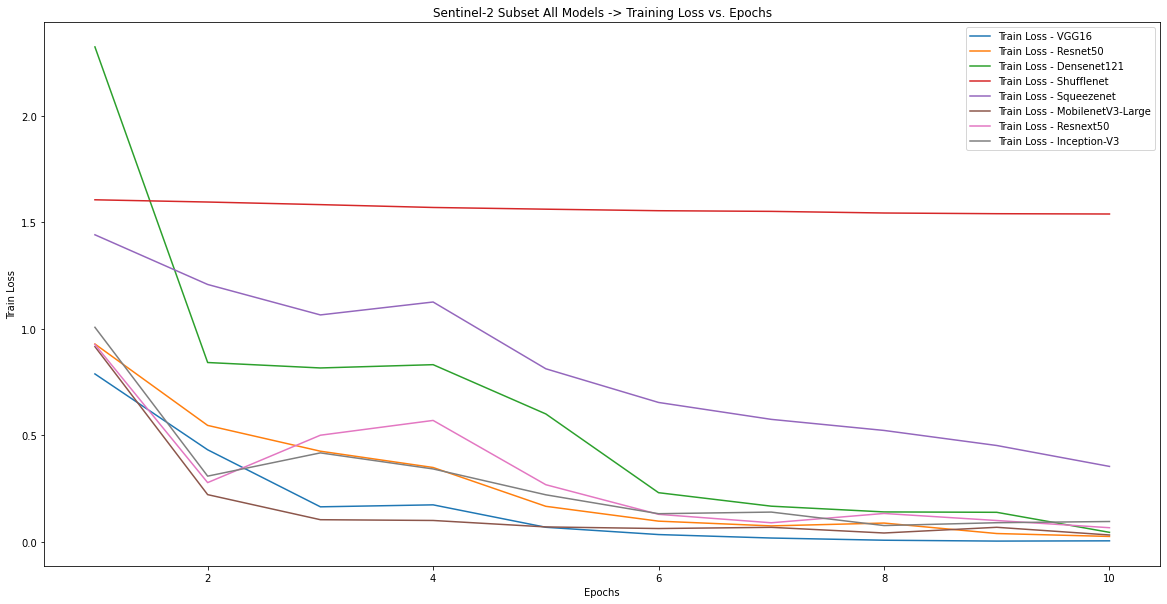

In [221]:
plt.figure(figsize = (20,10))


plt.plot(list_epochs,train_loss_vgg,label='Train Loss - VGG16')
plt.plot(list_epochs,train_loss_resnet,label='Train Loss - Resnet50')
plt.plot(list_epochs,train_loss_densenet,label='Train Loss - Densenet121')
plt.plot(list_epochs,train_loss_shufflenet,label='Train Loss - Shufflenet')
plt.plot(list_epochs,train_loss_squeezenet,label='Train Loss - Squeezenet')
plt.plot(list_epochs,train_loss_mobilenetv3,label='Train Loss - MobilenetV3-Large')
plt.plot(list_epochs,train_loss_resnext50,label='Train Loss - Resnext50')
plt.plot(list_epochs,train_loss_inceptionv3,label='Train Loss - Inception-V3')


plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Sentinel-2 Subset All Models -> Training Loss vs. Epochs')
plt.legend()


# **Test Loss Plot vs Epochs for All Models**

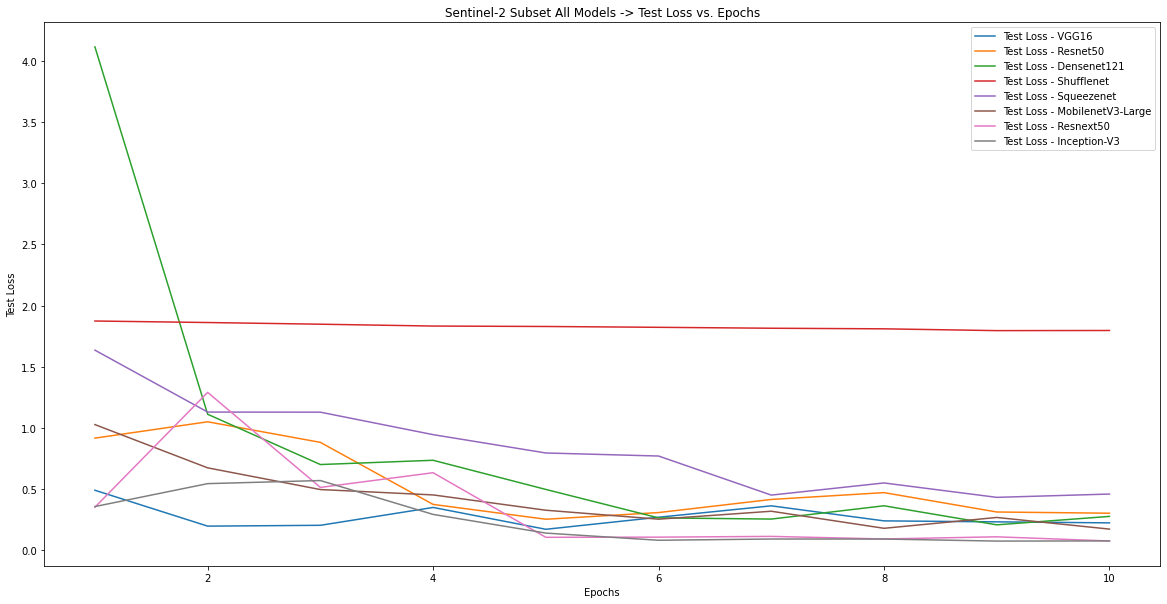

In [222]:
plt.figure(figsize = (20,10))


plt.plot(list_epochs,test_loss_vgg,label='Test Loss - VGG16')
plt.plot(list_epochs,test_loss_resnet,label='Test Loss - Resnet50')
plt.plot(list_epochs,test_loss_densenet,label='Test Loss - Densenet121')
plt.plot(list_epochs,test_loss_shufflenet,label='Test Loss - Shufflenet')
plt.plot(list_epochs,test_loss_squeezenet,label='Test Loss - Squeezenet')
plt.plot(list_epochs,test_loss_mobilenetv3,label='Test Loss - MobilenetV3-Large')
plt.plot(list_epochs,test_loss_resnext50,label='Test Loss - Resnext50')
plt.plot(list_epochs,test_loss_inceptionv3,label='Test Loss - Inception-V3')


plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Sentinel-2 Subset All Models -> Test Loss vs. Epochs')

plt.legend()


## **Reference**

https://pytorch.org/vision/stable/models.html